In [5]:
import sys
sys.path.insert(0, '/home/johnr_000/jupyter_blog/jupyter_blog/scripts')
import eia_model as em
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from datetime import datetime

In [6]:
#variables to specify date range and frequency
api_key = em.eia_api
start = '2015-12-01 01:00:00'
end = '2016-01-31 23:00:00'
freq = 'H'
# create list of series used for dictionary keys
keys = ['EBA.BPAT-ALL.D.H', 'EBA.PACE-ALL.D.H', 'EBA.PACW-ALL.D.H', 
        'EBA.PGE-ALL.D.H', 'EBA.PSEI-ALL.D.H', 'EBA.SCL-ALL.D.H']
# create dict of GetSeriesRange objects from series list
series_dict = {key: em.GetSeries(api_key=api_key, series_id=key, 
                                   start=start, end=end, freq=freq) for key in keys}

In [20]:
# loop over dictionary and print out full name of each series
for key in series_dict:
    print('{}: {}'.format(series_dict[key].data.series[0]['name'],key))

Demand for PacifiCorp West (PACW), Hourly: EBA.PACW-ALL.D.H
Demand for Seattle City Light (SCL), Hourly: EBA.SCL-ALL.D.H
Demand for Portland General Electric Company (PGE), Hourly: EBA.PGE-ALL.D.H
Demand for Puget Sound Energy, Inc. (PSEI), Hourly: EBA.PSEI-ALL.D.H
Demand for Bonneville Power Administration (BPAT), Hourly: EBA.BPAT-ALL.D.H
Demand for PacifiCorp East (PACE), Hourly: EBA.PACE-ALL.D.H


In [21]:
# all the dataframes have the same date range so we can concatenate in a loop
concat_df = pd.concat([series_dict[key].data.df for key in series_dict], axis=1)
# and output as a pickle file - I'm doing this to avoid calling the EIA API as I develop
concat_df.to_pickle('data/nw_load_df.pkl')
# concat_df = pd.read_pickle('data/new_load_df.pkl')

In [11]:
concat_df = pd.read_pickle('/home/johnr_000/jupyter_blog/jupyter_blog/data/nw_load_df.pkl')

In [15]:
concat_df['HOUR'] = concat_df.index.to_datetime().hour

In [21]:
def predict_outliers(series_id, train_df):
    '''
    Creates a dataframe with outlier prediction (boolean) and decision function
    :param series_id: a valid eia series with eia dataframe object
    :param train_df: a dataframe with the training series(x and y values)
    '''
    training_data = concat_df[['HOUR', series_id]].values
    clf = IsolationForest(contamination=.01)
    clf.fit(training_data)
    opred = clf.predict(training_data)
    dfunc = clf.decision_function(training_data)
    l1 = '{}{}'.format(series_id, '_opred')
    l2 = '{}{}'.format(series_id, 'dfunc')
    return pd.DataFrame(np.column_stack((opred, dfunc)), index=train_df.index.values, columns=[l1, l2])

In [22]:
test = predict_outliers('EBA.PACW-ALL.D.H', concat_df)

In [24]:
test[test['EBA.PACW-ALL.D.H_opred']== -1]

,EBA.PACW-ALL.D.H_opred,EBA.PACW-ALL.D.Hdfunc
2015-12-01 02:00:00,-1.0,-0.086333
2015-12-01 03:00:00,-1.0,-0.075916
2015-12-01 16:00:00,-1.0,-0.078645
2015-12-01 17:00:00,-1.0,-0.075124
2015-12-08 04:00:00,-1.0,-0.187347
2015-12-08 17:00:00,-1.0,-0.129624
2015-12-09 02:00:00,-1.0,-0.179766
2015-12-31 17:00:00,-1.0,-0.079289
2016-01-02 18:00:00,-1.0,-0.077722
2016-01-05 23:00:00,-1.0,-0.175516


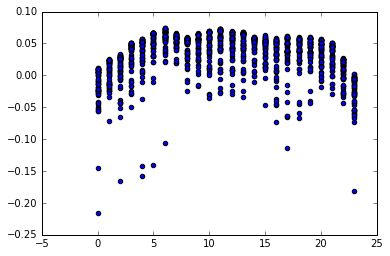

In [49]:
plt.scatter(concat_df['HOUR'].values, test)
plt.show()

In [50]:
test2 = np.column_stack((concat_df.index.values, concat_df['EBA.PACW-ALL.D.H'].values, test, y_pred_train))
test2_df = pd.DataFrame(data=test2)

In [51]:
test2_df[test2_df[3] == -1]

,0,1,2,3
0,2015-12-01 01:00:00,3353,-0.0715425,-1
1,2015-12-01 02:00:00,3468,-0.0660252,-1
15,2015-12-01 16:00:00,3533,-0.0729803,-1
142,2015-12-06 23:00:00,2337,-0.073346,-1
171,2015-12-08 04:00:00,68121,-0.158014,-1
184,2015-12-08 17:00:00,648,-0.113991,-1
193,2015-12-09 02:00:00,68178,-0.16574,-1
785,2016-01-02 18:00:00,3432,-0.0667889,-1
862,2016-01-05 23:00:00,-6763,-0.181341,-1
863,2016-01-06 00:00:00,12633,-0.144949,-1
